In [1]:
import torch
import torch.nn as nn
import numpy as np

Model

In [3]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super(Encoder, self).__init__()

    self.FC_input = nn.Linear(input_dim, hidden_dim)
    self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
    self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
    self.FC_var   = nn.Linear (hidden_dim, latent_dim)

    self.LeakyReLU = nn.LeakyReLU(0.2)
    self.training = True
  def forward(self, X):
    h_ = self.LeakyReLU(self.FC_input(X))
    h_ = self.LeakyReLU(self.FC_input2(h_))
    mean = self.FC_mean(h_)
    log_var = self.FC_var(h_)

    return mean, log_var

class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super(Decoder, self).__init__()
    self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
    self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
    self.FC_output = nn.Linear(hidden_dim, output_dim)

    self.LeakyReLU = nn.LeakyReLU(0.2)

  def forward(self, x):
    h     = self.LeakyReLU(self.FC_hidden(x))
    h     = self.LeakyReLU(self.FC_hidden2(h))

    x_hat = torch.sigmoid(self.FC_output(h))
    return x_hat

In [4]:
class Model(nn.Module):
  def __init__(self, Encoder, Decoder):
    super(Model, self).__init__()
    self.Encoder = Encoder
    self.Decoder = Decoder

  def RT(self, mean, var):
    epsilon = torch.randn_like(var).to(DEVICE)
    z = mean + var*epsilon
    return z

  def forward(self, x):
    mean, log_var = self.Encoder(x)
    z = self.RT(mean, torch.exp(0.5*log_var))# takes exponential function (log var -> var)
    x_hat = self.Decoder(z)
    return x_hat, mean, log_var

In [6]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [7]:
#Loss Function
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

Training_Example

In [8]:
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [11]:
# Model Hyperparameters

dataset_path = '~/datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 3

In [9]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True}

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.89MB/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 127kB/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 244kB/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]

Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



In [12]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        overall_loss += loss.item()

        loss.backward()
        optimizer.step()

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  135.1661980742644
	Epoch 2 complete! 	Average Loss:  117.91859048935726
	Epoch 3 complete! 	Average Loss:  112.78917042727463
Finish!!


Gen images

In [13]:
import matplotlib.pyplot as plt

In [14]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        x_hat, _, _ = model(x)


        break

  0%|          | 0/100 [00:00<?, ?it/s]


In [15]:
def show_image(x, idx):
    x = x.view(batch_size, 28, 28)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

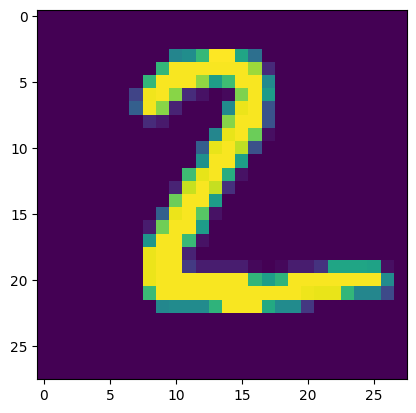

In [17]:
show_image(x, idx=1)

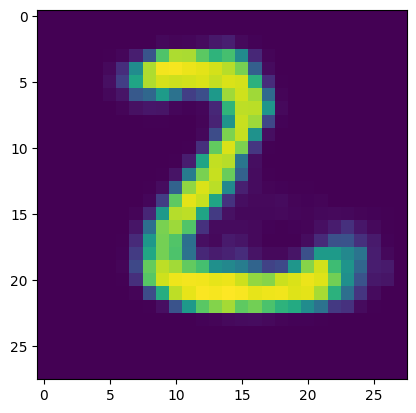

In [19]:
show_image(x_hat, idx=1)

Generate image from noise vector

In [20]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [21]:
save_image(generated_images.view(batch_size, 1, 28, 28), 'generated_sample.png')

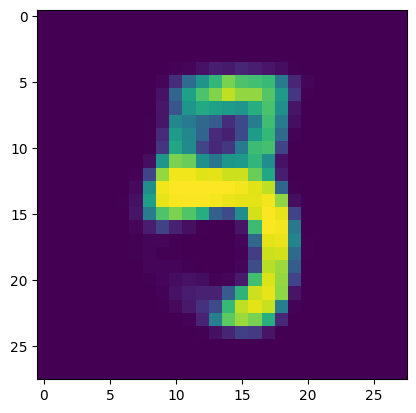

In [22]:
show_image(generated_images, idx=12)

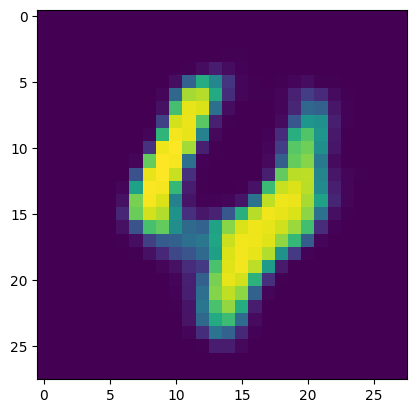

In [24]:
show_image(generated_images, idx=1)